# Fraud Detection Model
## Using processed transaction data to build a fraud classification model.

In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)

import joblib


## Paths

In [2]:

PROJECT_ROOT = Path("../")
DATA_PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MODEL_DIR = PROJECT_ROOT / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

FRAUD_DATA_PATH = DATA_PROCESSED_DIR / "fraud_model_dataset.csv"
print("Fraud dataset path:", FRAUD_DATA_PATH.resolve())

Fraud dataset path: /Users/goureshmadye/Documents/DataAnalyst/Integrated-Banking-Insights-Risk-Customer-Analytics/data/processed/fraud_model_dataset.csv


## Load Fraud Dataset

In [3]:
df = pd.read_csv(FRAUD_DATA_PATH)
print(df.shape)
df.head()

(5389, 17)


,Transaction_ID,Account_Number,Transaction_Amount,Transaction_Type,Category,Payment_Method,Transaction_Status,Customer_Age,Customer_Income,Account_Balance,transaction_year,transaction_month,transaction_day,transaction_hour,day_of_week,is_weekend,Fraud_Flag
0,bdd640fb-0667-4ad1-9c80-317fa3b1799d,IUPM04409079772781,3198.94,Debit,Transport,Online Transfer,Failed,55,80466.03,350.28,2023,2023-11,5,15,6,1,0
1,23b8c1e9-3924-46de-beb1-3b9046685257,BLAT22216107051843,129.93,Credit,Grocery,Debit Card,Pending,26,145574.25,9797.81,2024,2024-04,21,22,6,1,1
2,bd9c66b3-ad3c-4d6d-9a3d-1fa7bc8960a9,UTXA55295806601382,1378.77,Credit,Shopping,Debit Card,Failed,29,33447.18,12399.85,2023,2023-07,17,13,0,0,1
3,972a8469-1641-4f82-8b9d-2434e465e150,XICF70493862044851,1119.94,Credit,Healthcare,Online Transfer,Failed,60,108801.45,16057.64,2023,2023-06,27,16,1,0,1
4,17fc695a-07a0-4a6e-8822-e8f36c031199,KOSW19711121259020,3683.67,Credit,Entertainment,E-Wallet,Failed,29,100985.12,14940.54,2024,2024-03,26,23,1,0,1


## Basic Info & Target Distribution

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5389 entries, 0 to 5388
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction_ID      5389 non-null   object 
 1   Account_Number      5389 non-null   object 
 2   Transaction_Amount  5389 non-null   float64
 3   Transaction_Type    5389 non-null   object 
 4   Category            5389 non-null   object 
 5   Payment_Method      5389 non-null   object 
 6   Transaction_Status  5389 non-null   object 
 7   Customer_Age        5389 non-null   int64  
 8   Customer_Income     5389 non-null   float64
 9   Account_Balance     5389 non-null   float64
 10  transaction_year    5389 non-null   int64  
 11  transaction_month   5389 non-null   object 
 12  transaction_day     5389 non-null   int64  
 13  transaction_hour    5389 non-null   int64  
 14  day_of_week         5389 non-null   int64  
 15  is_weekend          5389 non-null   int64  
 16  Fraud_

## Check target balance

df["Fraud_Flag"].value_counts(dropna=False), df["Fraud_Flag"].value_counts(normalize=True)

## Visualize Imbalance

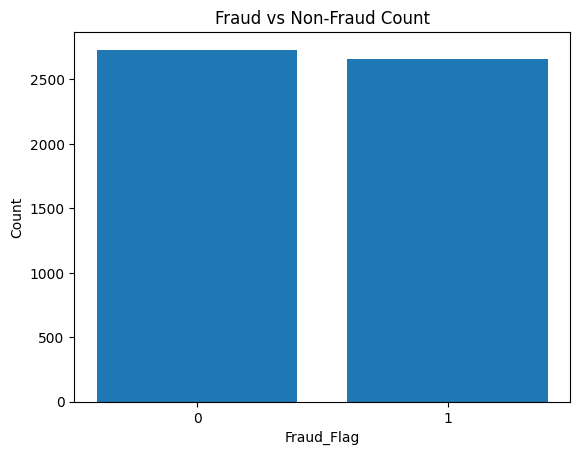

In [5]:
fraud_counts = df["Fraud_Flag"].value_counts()
plt.bar(fraud_counts.index.astype(str), fraud_counts.values)
plt.title("Fraud vs Non-Fraud Count")
plt.xlabel("Fraud_Flag")
plt.ylabel("Count")
plt.show()

## Train / Test Split

In [6]:
# Prefer time-based split if transaction_year exists
if "transaction_year" in df.columns:
    print("Using time-based split by transaction_year")

    # Ensure years are numeric
    df["transaction_year"] = pd.to_numeric(df["transaction_year"], errors="coerce")

    train_df = df[df["transaction_year"] <= 2023].copy()
    test_df = df[df["transaction_year"] >= 2024].copy()

    print("Train shape:", train_df.shape)
    print("Test shape :", test_df.shape)
else:
    print("transaction_year not found. Using random train_test_split instead.")
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Fraud_Flag"])
    print("Train shape:", train_df.shape)
    print("Test shape :", test_df.shape)

Using time-based split by transaction_year
Train shape: (2556, 17)
Test shape : (2833, 17)


## Dropping non-feature columns

In [7]:
TARGET_COL = "Fraud_Flag"

drop_cols = ["Transaction_ID", "Account_Number"]

X_train = train_df.drop(columns=[c for c in drop_cols if c in train_df.columns] + [TARGET_COL])
y_train = train_df[TARGET_COL]

X_test = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns] + [TARGET_COL])
y_test = test_df[TARGET_COL]

X_train.head()

,Transaction_Amount,Transaction_Type,Category,Payment_Method,Transaction_Status,Customer_Age,Customer_Income,Account_Balance,transaction_year,transaction_month,transaction_day,transaction_hour,day_of_week,is_weekend
0,3198.94,Debit,Transport,Online Transfer,Failed,55,80466.03,350.28,2023,2023-11,5,15,6,1
2,1378.77,Credit,Shopping,Debit Card,Failed,29,33447.18,12399.85,2023,2023-07,17,13,0,0
3,1119.94,Credit,Healthcare,Online Transfer,Failed,60,108801.45,16057.64,2023,2023-06,27,16,1,0
5,3385.11,Debit,Healthcare,Credit Card,Success,21,102713.53,7768.29,2023,2023-08,6,20,6,1
6,4461.44,Credit,Savings,Debit Card,Pending,41,63919.32,5437.07,2023,2023-04,20,22,3,0


## Preprocessing: ColumnTransformer

In [8]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric features    :", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

Numeric features    : ['Transaction_Amount', 'Customer_Age', 'Customer_Income', 'Account_Balance', 'transaction_year', 'transaction_day', 'transaction_hour', 'day_of_week', 'is_weekend']
Categorical features: ['Transaction_Type', 'Category', 'Payment_Method', 'Transaction_Status', 'transaction_month']


## Baseline Model: Logistic Regression

In [9]:
log_reg_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        (
            "model",
            LogisticRegression(
                max_iter=200,
                class_weight="balanced",  # handle imbalance
                n_jobs=-1,
            ),
        ),
    ]
)

log_reg_clf.fit(X_train, y_train)

y_pred_lr = log_reg_clf.predict(X_test)
y_proba_lr = log_reg_clf.predict_proba(X_test)[:, 1]

print("LogReg Classification Report:\n")
print(classification_report(y_test, y_pred_lr))

roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
print("LogReg ROC-AUC:", roc_auc_lr)

LogReg Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.56      0.54      1413
           1       0.52      0.49      0.50      1420

    accuracy                           0.52      2833
   macro avg       0.52      0.52      0.52      2833
weighted avg       0.52      0.52      0.52      2833

LogReg ROC-AUC: 0.5137451033162883


## Detailed Plots for more insights

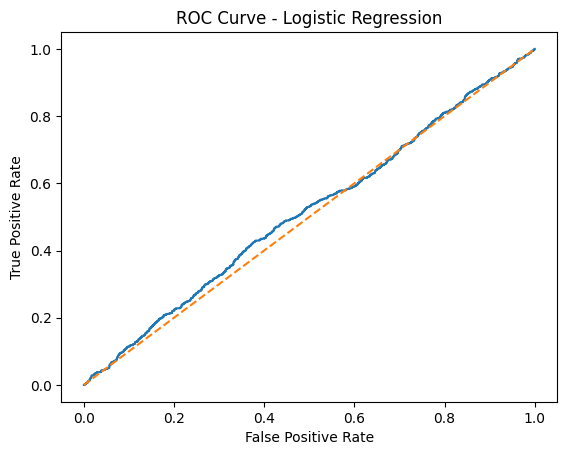

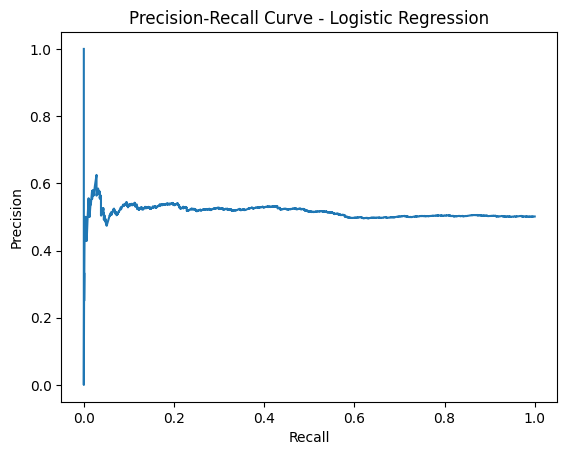

In [10]:
fpr, tpr, _ = roc_curve(y_test, y_proba_lr)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

prec, rec, _ = precision_recall_curve(y_test, y_proba_lr)
plt.plot(rec, prec)
plt.title("Precision-Recall Curve - Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## Main Model: Random Forest

In [11]:
rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        (
            "model",
            RandomForestClassifier(
                n_estimators=200,
                max_depth=None,
                min_samples_split=5,
                min_samples_leaf=2,
                class_weight="balanced",  # again, handle imbalance
                n_jobs=-1,
                random_state=42,
            ),
        ),
    ]
)

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print("Random Forest ROC-AUC:", roc_auc_rf)

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.59      0.55      1413
           1       0.51      0.42      0.46      1420

    accuracy                           0.51      2833
   macro avg       0.51      0.51      0.50      2833
weighted avg       0.51      0.51      0.50      2833

Random Forest ROC-AUC: 0.5091708780638537


## Confusion Matrix

In [12]:
cm = confusion_matrix(y_test, y_pred_rf)
cm

array([[839, 574],
       [826, 594]])

## ROC / PR curves


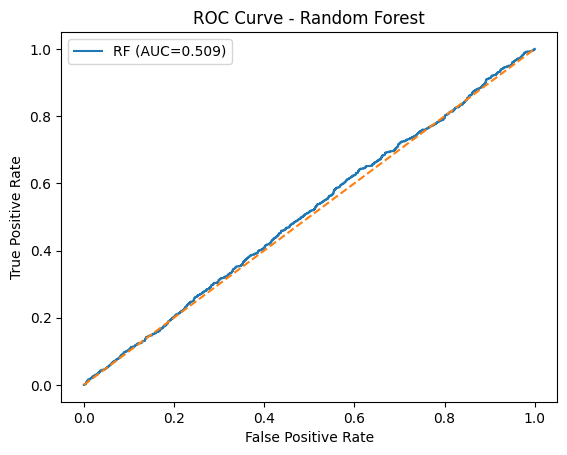

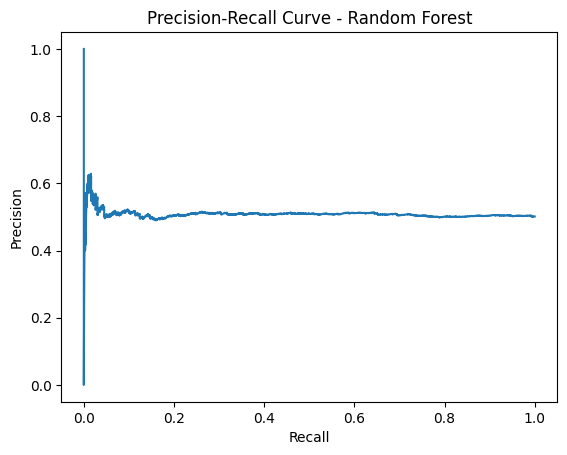

In [13]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={roc_auc_rf:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_proba_rf)
plt.plot(rec_rf, prec_rf)
plt.title("Precision-Recall Curve - Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## Threshold Tuning 

In [14]:
thresholds = np.linspace(0.1, 0.9, 9)
results = []

for thr in thresholds:
    y_thr = (y_proba_rf >= thr).astype(int)
    report = classification_report(y_test, y_thr, output_dict=True)
    results.append(
        {
            "threshold": thr,
            "precision_fraud": report["1"]["precision"],
            "recall_fraud": report["1"]["recall"],
            "f1_fraud": report["1"]["f1-score"],
        }
    )

thr_df = pd.DataFrame(results)
thr_df

/Users/goureshmadye/Documents/DataAnalyst/Integrated-Banking-Insights-Risk-Customer-Analytics/venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/goureshmadye/Documents/DataAnalyst/Integrated-Banking-Insights-Risk-Customer-Analytics/venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/goureshmadye/Documents/DataAnalyst/Integrated-Banking-Insights-Risk-Customer-Analytics/venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetr

,threshold,precision_fraud,recall_fraud,f1_fraud
0,0.1,0.501235,1.000000,0.667764
1,0.2,0.501235,1.000000,0.667764
2,0.3,0.500885,0.996479,0.666667
3,0.4,0.502984,0.890141,0.642766
4,0.5,0.508562,0.418310,0.459042
5,0.6,0.525000,0.044366,0.081818
6,0.7,0.000000,0.000000,0.000000
7,0.8,0.000000,0.000000,0.000000
8,0.9,0.000000,0.000000,0.000000


## Saving Final Model

In [15]:
MODEL_PATH = MODEL_DIR / "fraud_detection_rf.joblib"
joblib.dump(rf_clf, MODEL_PATH)
print("Saved Random Forest pipeline to:", MODEL_PATH)

Saved Random Forest pipeline to: ../models/fraud_detection_rf.joblib
